In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate artificial prices as per the paper
def generate_artificial_prices(T=10000, alpha=0.9, k=3):
    eps = np.random.normal(0, 1, T)
    nu = np.random.normal(0, 1, T)
    beta = np.zeros(T + 1)
    p = np.zeros(T + 1)
    for t in range(1, T + 1):
        beta[t] = alpha * beta[t-1] + nu[t-1]
        p[t] = p[t-1] + beta[t-1] + k * eps[t-1]
    R = np.max(p[1:]) - np.min(p[1:])
    z = np.exp(p[1:] / R)
    return z

# Parameters
T = 10000  # Time steps
m = 8  # Number of lagged returns
n_params = m + 2  # w (bias), u (F_{t-1}), v_1 to v_8
theta = np.random.normal(0, 0.1, n_params)  # Random initialization
delta = 0.005  # Transaction cost 0.5%
eta = 0.01  # Decay factor for moving averages (1/eta = 100 periods)
rho = 0.001  # Learning rate

# Generate prices and returns
prices = generate_artificial_prices(T=T)
returns = np.diff(prices, prepend=prices[0])  # r_t = z_t - z_{t-1}

# Initialize trader variables
F_prev = 0.0  # Initial position F_0
P_prev = np.zeros(n_params)  # Gradient dF_t/dθ
A = 0.0  # Moving average of returns
B = 0.0  # Moving average of squared returns

# Storage for results
F_list = [F_prev]
R_list = []
A_list = []
B_list = []

# Real-time recurrent learning simulation
for t in range(1, T + 1):
    r_t = returns[t - 1]
    # Construct input vector: [1, F_{t-1}, r_{t-1}, ..., r_{t-8}]
    x_t = np.zeros(n_params)
    x_t[0] = 1.0  # Bias term
    x_t[1] = F_prev
    for i in range(1, m + 1):
        if t - i >= 1:
            x_t[i + 1] = returns[t - i - 1]
        else:
            x_t[i + 1] = 0.0
    # Compute trader output
    a_t = np.dot(theta, x_t)
    F_t = np.tanh(a_t)  # Continuous position in [-1, 1]
    # Compute gradient dF_t/dθ using RTRL
    P_t = (1 - F_t**2) * (x_t + theta[1] * P_prev)
    # Compute trading return
    R_t = F_prev * r_t - delta * np.abs(F_t - F_prev)
    # Update moving averages
    A = A + eta * (R_t - A)
    B = B + eta * (R_t**2 - B)
    # Compute differential Sharpe ratio gradient
    if B - A**2 > 0:
        dD_dR_t = (B - A * R_t) / (B - A**2)**1.5
    else:
        dD_dR_t = 0.0
    # Compute dR_t/dθ
    sign_diff = np.sign(F_t - F_prev) if F_t != F_prev else 0
    dR_dtheta = r_t * P_prev - delta * sign_diff * (P_t - P_prev)
    # Update parameters
    delta_theta = rho * dD_dR_t * dR_dtheta
    theta = theta + delta_theta
    # Store results
    F_list.append(F_t)
    R_list.append(R_t)
    A_list.append(A)
    B_list.append(B)
    # Update previous values
    F_prev = F_t
    P_prev = P_t

# Compute cumulative profit and Sharpe ratio
cum_profit = np.cumsum(R_list)
sharpe_ratio = []
for t in range(T):
    if B_list[t] - A_list[t]**2 > 0:
        S_t = A_list[t] / np.sqrt(B_list[t] - A_list[t]**2)
    else:
        S_t = 0.0
    sharpe_ratio.append(S_t)

# Figure 2: Time series plots
fig, axs = plt.subplots(4, 1, figsize=(12, 16))
axs[0].plot(prices)
axs[0].set_title('Price Series')
axs[1].plot(F_list[1:])
axs[1].set_title('Trading Signals (F_t)')
axs[2].plot(cum_profit)
axs[2].set_title('Cumulative Profit')
axs[3].plot(sharpe_ratio)
axs[3].set_title('Exponential Moving Sharpe Ratio')
plt.tight_layout()
plt.savefig('figure_2.png')
plt.close()

# Figure 4: Histograms
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
# Price changes
axs[0, 0].hist(returns[:5000], bins=50)
axs[0, 0].set_title('Price Changes (First 5000)')
axs[0, 1].hist(returns[5000:], bins=50)
axs[0, 1].set_title('Price Changes (Last 5000)')
# Trading profits
axs[1, 0].hist(R_list[:5000], bins=50)
axs[1, 0].set_title('Trading Profits (First 5000)')
axs[1, 1].hist(R_list[5000:], bins=50)
axs[1, 1].set_title('Trading Profits (Last 5000)')
# Sharpe ratios
axs[2, 0].hist(sharpe_ratio[:5000], bins=50)
axs[2, 0].set_title('Sharpe Ratios (First 5000)')
axs[2, 1].hist(sharpe_ratio[5000:], bins=50)
axs[2, 1].set_title('Sharpe Ratios (Last 5000)')
plt.tight_layout()
plt.savefig('figure_4.png')
plt.close()

print("Simulation complete. Plots saved as 'figure_2.png' and 'figure_4.png'.")

Simulation complete. Plots saved as 'figure_2.png' and 'figure_4.png'.


Starting training...
Training complete.
Starting testing...
Testing complete.


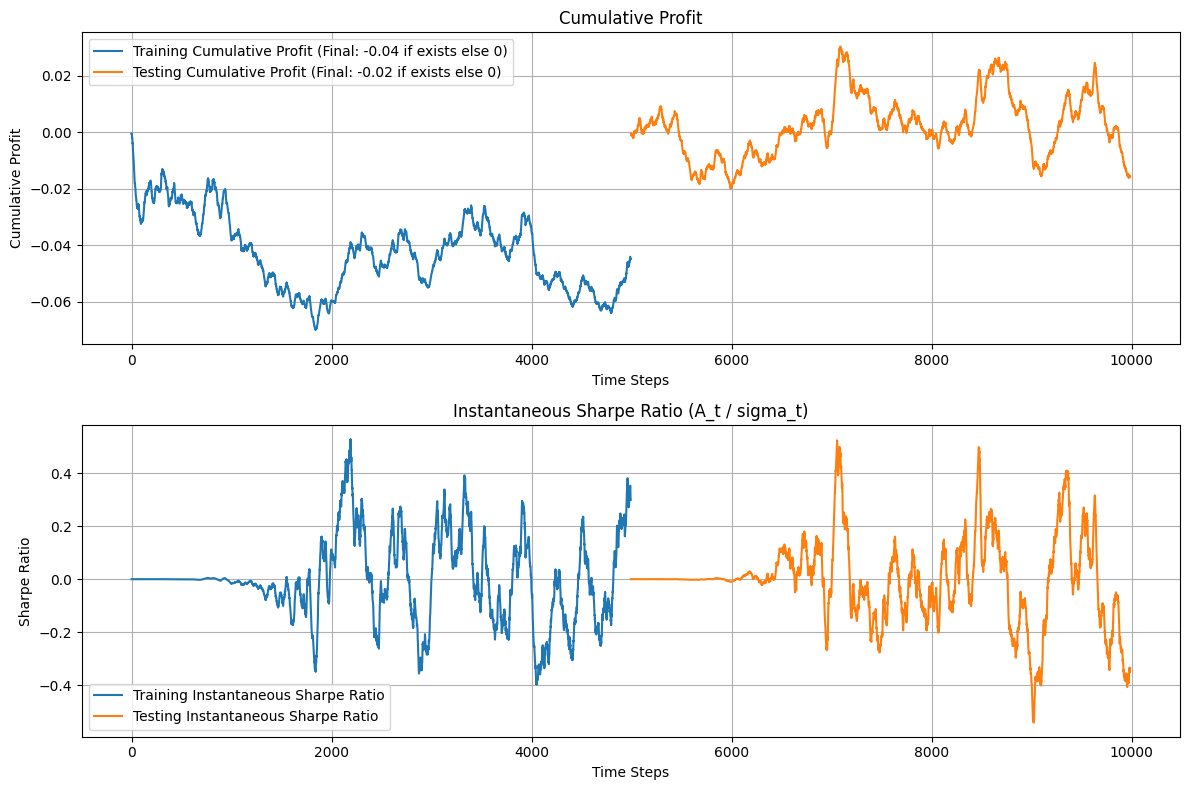

Plotting complete. Results saved as 'rrl_results_fixed.png'.
Final Training Cumulative Profit: -0.0449
Average Training Sharpe Ratio: 0.0004
Final Test Cumulative Profit: -0.0156
Average Test Sharpe Ratio: -0.0034


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt 

# Generate artificial prices as per the RRL paper (user's provided function)
def generate_artificial_prices(T=10000, alpha=0.9, k=3):
    eps = np.random.normal(0, 1, T)
    nu = np.random.normal(0, 1, T)
    beta = np.zeros(T + 1)
    p = np.zeros(T + 1)
    for t in range(1, T + 1):
        beta[t] = alpha * beta[t-1] + nu[t-1]
        p[t] = p[t-1] + beta[t-1] + k * eps[t-1]
    R_norm = np.max(p[1:]) - np.min(p[1:]) # Renamed R to R_norm to avoid conflict
    if R_norm == 0: R_norm = 1 # Avoid division by zero if p is flat
    z = np.exp(p[1:] / R_norm)
    return z

# Parameters
T_total_data = 10000 # Total data points to generate
T_train = 5000      # Training time steps
T_test = T_total_data - T_train # Testing time steps
m = 8               # Number of lagged returns
n_params = m + 2    # Inputs: bias, F_{t-1}, r_{t-1}, ..., r_{t-m}
delta = 0.005       # Transaction cost (0.5%)
eta = 0.01          # Decay factor for moving averages (1/eta = 100 periods)
learning_rate = 0.001 # Learning rate for optimizer
epsilon_sharpe = 1e-9 # For numerical stability in Sharpe ratio calculation

# Generate price data
prices_full = generate_artificial_prices(T=T_total_data)

# Calculate returns: r_t = z_t - z_{t-1}
# The user's original `prepend=prices[0]` was unusual. Standard diff is used here.
# If prices_full = [p0, p1, p2, ...], returns_actual = [p1-p0, p2-p1, ...]
returns_actual = np.diff(prices_full, prepend=prices_full[0])  # r_t = z_t - z_{t-1}

# Ensure enough returns are generated
if len(returns_actual) < T_train + T_test:
    raise ValueError(f"Generated only {len(returns_actual)} returns, but need {T_train + T_test}. Increase T in generate_artificial_prices.")

train_returns_np = returns_actual[:T_train]
test_returns_np = returns_actual[T_train : T_train + T_test]


# Define the RRLTrader model
class RRLTrader(nn.Module):
    def __init__(self, n_input_features): # Changed n_params to n_input_features for clarity
        super(RRLTrader, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        return self.tanh(self.linear(x))

# Helper function to compute user's D_t and update A, B
def compute_D_t_and_update_AB(R_t_tensor, A_prev_tensor, B_prev_tensor, eta_val, epsilon=1e-9):
    # A_prev_tensor, B_prev_tensor are detached from previous step
    # R_t_tensor is part of current graph

    # Update A and B based on current R_t_tensor
    # These A_t_updated, B_t_updated will carry grad from R_t_tensor
    A_t_updated = A_prev_tensor + eta_val * (R_t_tensor - A_prev_tensor)
    B_t_updated = B_prev_tensor + eta_val * (R_t_tensor**2 - B_prev_tensor)

    # Calculate D_t using A_prev_tensor, B_prev_tensor for numerator terms involving them,
    # and A_t_updated, B_t_updated for the denominator's variance term.
    # This is specific to the user's D_t formula.
    numerator_D = B_prev_tensor * (R_t_tensor - A_prev_tensor) - 0.5 * A_prev_tensor * (R_t_tensor**2 - B_prev_tensor)
    denominator_variance_term = B_t_updated - A_t_updated**2
    
    if denominator_variance_term > epsilon: # Check for positive variance
        D_t_calculated = numerator_D / (denominator_variance_term**1.5)
    else:
        D_t_calculated = torch.tensor(0.0, device=R_t_tensor.device, dtype=R_t_tensor.dtype) # Ensure same device and dtype
    
    return D_t_calculated, A_t_updated, B_t_updated

# Training function
def train_model(model, returns_data_np, num_input_features, m_lags, transaction_delta, ema_eta, opt, epsilon_sr):
    F_prev = torch.tensor([0.0], requires_grad=False, dtype=torch.float32)
    # Initialize A and B. Paper suggests B_0=1 for stability.
    A = torch.tensor(0.0, requires_grad=False, dtype=torch.float32)
    B = torch.tensor(1.0, requires_grad=False, dtype=torch.float32) # Initial B=1 for stability
    
    F_list_log = []
    R_list_log = []
    sharpe_ratio_log = []

    # Loop t_idx from m_lags to len(returns_data_np) - 1
    # This ensures returns_data_np[t_idx - 1 - lag_idx] is valid
    # returns_data_np[k] is r_{k+1} (market return at time k+1)
    # Current market return r_k (at time k) is returns_data_np[k-1] if loop is for time k
    # Let loop index `t_loop_idx` represent the time step for which we are deciding F.
    # The current return available at time `t_loop_idx` to decide `F_t_loop_idx` is `returns_data_np[t_loop_idx-1]` (if `t_loop_idx >=1`)
    # Lagged returns are `returns_data_np[t_loop_idx-1-lag_idx]`
    
    # The loop will go from t = m_lags up to T_train-1 (if returns_data_np has T_train elements)
    # This means we can form m_lags previous returns.
    # returns_data_np[t] is the return for period t+1.
    # If current time is `k`, the decision $F_k$ is made.
    # The return $r_k$ (from $z_{k-1}$ to $z_k$) is `returns_data_np[k-1]`.
    # Lagged returns are $r_{k-1}, \dots, r_{k-m\_lags}$.
    # $r_{k-j}$ corresponds to `returns_data_np[k-1-j]`.

    for t_idx in range(m_lags, len(returns_data_np)): # t_idx is the index for current return to be processed
        current_market_return_for_R_t = torch.tensor(returns_data_np[t_idx], dtype=torch.float32) # This is r_t (return from t-1 to t)

        # Prepare input: [1 (bias), F_{t-1}, r_{t-1}, ..., r_{t-m_lags}]
        # r_{t-1} is returns_data_np[t_idx-1], ..., r_{t-m_lags} is returns_data_np[t_idx-m_lags]
        x_input_features = torch.zeros(num_input_features, dtype=torch.float32)
        x_input_features[0] = 1.0  # Bias term
        x_input_features[1] = F_prev
        for lag_idx in range(m_lags): # lag_idx from 0 to m_lags-1
            # For r_{t-(lag_idx+1)}
            return_idx_for_lag = t_idx - 1 - lag_idx
            if return_idx_for_lag >= 0:
                 x_input_features[lag_idx + 2] = returns_data_np[return_idx_for_lag]
            # else: it remains 0.0 (e.g. for initial steps) - handled by starting loop at m_lags

        x_input_features = x_input_features.unsqueeze(0)  # Add batch dimension

        # Compute F_t
        F_t = model(x_input_features).squeeze() # Squeeze to make it scalar-like

        # Compute trading return R_t (using current_market_return_for_R_t as r_t)
        R_t = F_prev * current_market_return_for_R_t - transaction_delta * torch.abs(F_t - F_prev)

        # Compute D_t (user's formula) and update A, B
        # A, B passed here are A_{t-1}, B_{t-1} (values from previous iteration, already detached)
        D_term, A_updated_tensor, B_updated_tensor = compute_D_t_and_update_AB(R_t, A, B, ema_eta, epsilon_sr)

        # Loss is -D_term (to maximize D_term)
        loss = -D_term

        # Backpropagation and optimization
        opt.zero_grad()
        loss.backward() # This should work now
        opt.step()

        # Store results for logging
        F_list_log.append(F_t.item())
        R_list_log.append(R_t.item())
        
        # Calculate Sharpe ratio for logging using updated A and B
        # A_updated_tensor and B_updated_tensor are A_t and B_t for the current step
        current_variance = B_updated_tensor - A_updated_tensor**2
        if current_variance > epsilon_sr:
            S_t_current = A_updated_tensor / torch.sqrt(current_variance)
        else:
            S_t_current = torch.tensor(0.0, dtype=torch.float32)
        sharpe_ratio_log.append(S_t_current.item())

        # Update F_prev, A, B for the next iteration
        # CRITICAL: Detach A_updated_tensor and B_updated_tensor
        F_prev = F_t.detach()
        A = A_updated_tensor.detach()
        B = B_updated_tensor.detach()
        
    return F_list_log, R_list_log, sharpe_ratio_log

# Testing function
def test_model(model, returns_data_np, num_input_features, m_lags, transaction_delta, ema_eta, epsilon_sr):
    F_prev = torch.tensor([0.0], requires_grad=False, dtype=torch.float32)
    A = torch.tensor(0.0, requires_grad=False, dtype=torch.float32)
    B = torch.tensor(1.0, requires_grad=False, dtype=torch.float32) # Initial B=1
    
    F_list_log = []
    R_list_log = []
    sharpe_ratio_log = []

    with torch.no_grad():  # No gradient computation in testing
        for t_idx in range(m_lags, len(returns_data_np)):
            current_market_return_for_R_t = torch.tensor(returns_data_np[t_idx], dtype=torch.float32)

            x_input_features = torch.zeros(num_input_features, dtype=torch.float32)
            x_input_features[0] = 1.0
            x_input_features[1] = F_prev
            for lag_idx in range(m_lags):
                return_idx_for_lag = t_idx - 1 - lag_idx
                if return_idx_for_lag >=0:
                     x_input_features[lag_idx + 2] = returns_data_np[return_idx_for_lag]
            x_input_features = x_input_features.unsqueeze(0)

            F_t = model(x_input_features).squeeze()
            R_t = F_prev * current_market_return_for_R_t - transaction_delta * torch.abs(F_t - F_prev)
            
            # In test mode, D_term is not used for optimization, but A, B are updated for Sharpe Ratio logging
            _ , A_updated_tensor, B_updated_tensor = compute_D_t_and_update_AB(R_t, A, B, ema_eta, epsilon_sr)

            F_list_log.append(F_t.item())
            R_list_log.append(R_t.item())

            current_variance = B_updated_tensor - A_updated_tensor**2
            if current_variance > epsilon_sr:
                S_t_current = A_updated_tensor / torch.sqrt(current_variance)
            else:
                S_t_current = torch.tensor(0.0, dtype=torch.float32)
            sharpe_ratio_log.append(S_t_current.item())
            
            F_prev = F_t # No detach needed as F_t was created in no_grad context
            A = A_updated_tensor # No detach needed
            B = B_updated_tensor # No detach needed

    return F_list_log, R_list_log, sharpe_ratio_log

# Initialize model and optimizer
# n_params is num_input_features
rrl_model = RRLTrader(n_input_features=n_params)
optimizer = optim.Adam(rrl_model.parameters(), lr=learning_rate)

# Train the model
print("Starting training...")
train_F, train_R, train_sharpe = train_model(rrl_model, train_returns_np, n_params, m, delta, eta, optimizer, epsilon_sharpe)
print("Training complete.")

# Test the model
print("Starting testing...")
test_F, test_R, test_sharpe = test_model(rrl_model, test_returns_np, n_params, m, delta, eta, epsilon_sharpe)
print("Testing complete.")

# Compute cumulative profits
train_cum_profit = np.cumsum(train_R)
test_cum_profit = np.cumsum(test_R)

# Plot results
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(train_cum_profit, label=f'Training Cumulative Profit (Final: {train_cum_profit[-1]:.2f} if exists else 0)')
# Adjust x-axis for test plot
if len(train_cum_profit) > 0 and len(test_cum_profit) > 0:
    test_x_axis = range(len(train_cum_profit), len(train_cum_profit) + len(test_cum_profit))
    plt.plot(test_x_axis, test_cum_profit, label=f'Testing Cumulative Profit (Final: {test_cum_profit[-1]:.2f} if exists else 0)')
elif len(test_cum_profit) > 0 :
    plt.plot(test_cum_profit, label=f'Testing Cumulative Profit (Final: {test_cum_profit[-1]:.2f} if exists else 0)')

plt.title('Cumulative Profit')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Profit')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(train_sharpe, label='Training Instantaneous Sharpe Ratio')
if len(train_sharpe) > 0 and len(test_sharpe) > 0:
    test_x_axis_sharpe = range(len(train_sharpe), len(train_sharpe) + len(test_sharpe))
    plt.plot(test_x_axis_sharpe, test_sharpe, label='Testing Instantaneous Sharpe Ratio')
elif len(test_sharpe) > 0:
     plt.plot(test_sharpe, label='Testing Instantaneous Sharpe Ratio')

plt.title('Instantaneous Sharpe Ratio (A_t / sigma_t)')
plt.xlabel('Time Steps')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('rrl_results_fixed.png')
plt.show()
plt.close()

print("Plotting complete. Results saved as 'rrl_results_fixed.png'.")
if len(train_R) > 0:
    print(f"Final Training Cumulative Profit: {train_cum_profit[-1]:.4f}")
    print(f"Average Training Sharpe Ratio: {np.mean(train_sharpe):.4f}")
if len(test_R) > 0:
    print(f"Final Test Cumulative Profit: {test_cum_profit[-1]:.4f}")
    print(f"Average Test Sharpe Ratio: {np.mean(test_sharpe):.4f}")

